# Treinamento CIS - 1º Período (Classificação)

## Importação do dataset


Importação das bibliotecas usadas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Importação do dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/adult.csv") #, sep=';'

## Conhecendo o dataset


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Algumas colunas são variáveis ​​contínuas. Aquelas que o dtype é object precisam ser codificado para variáveis contínuas para serem utilizáveis.

In [ ]:
categorical_cols = ["workclass", "education", "marital.status", "occupation",
                    "relationship", "race", "sex", "native.country", "income"]

# Applying one-hot encoding while dropping the first category to avoid multicollinearity
encoded_df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Display new data types after encoding
print(encoded_df.dtypes)

age                               int64
fnlwgt                            int64
education.num                     int64
capital.gain                      int64
capital.loss                      int64
                                  ...  
native.country_Trinadad&Tobago     bool
native.country_United-States       bool
native.country_Vietnam             bool
native.country_Yugoslavia          bool
income_>50K                        bool
Length: 101, dtype: object


Estas são todas as novas colunas de encoded_df:

In [ ]:
column_names = encoded_df.columns.tolist()
print(column_names)


['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week', 'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc', 'workclass_State-gov', 'workclass_Without-pay', 'education_11th', 'education_12th', 'education_1st-4th', 'education_5th-6th', 'education_7th-8th', 'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc', 'education_Bachelors', 'education_Doctorate', 'education_HS-grad', 'education_Masters', 'education_Preschool', 'education_Prof-school', 'education_Some-college', 'marital.status_Married-AF-spouse', 'marital.status_Married-civ-spouse', 'marital.status_Married-spouse-absent', 'marital.status_Never-married', 'marital.status_Separated', 'marital.status_Widowed', 'occupation_Adm-clerical', 'occupation_Armed-Forces', 'occupation_Craft-repair', 'occupation_Exec-managerial', 'occupation_Farming-fishing', 'occupation_Handlers-cleaners', 'occupation_Machine

Como o código acaba separando colunas para income>50k e income<=50k, transformarei novamente em uma coluna só, chamada income, porém agora ela será uma int64, não object. Isso facilitará o desenvolvimento do projeto.

In [ ]:
# Convert boolean column to integer (0 and 1)
encoded_df["income"] = encoded_df["income_>50K"].astype(int)

# Drop the extra column (optional cleanup)
encoded_df.drop(columns=["income_>50K"], inplace=True)

# Check that the fix worked
print(encoded_df["income"].value_counts())  # Should show both 0s and 1s


income
0    24720
1     7841
Name: count, dtype: int64


De acordo com as informações disponíveis na página do dataset no Kaggle:

**Description of fnlwgt (final weight)**: The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian noninstitutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

* A single cell estimate of the population 16+ for each state.

* Controls for Hispanic Origin by age and sex.

* Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

Dataset disponível em: https://www.kaggle.com/datasets/uciml/adult-census-income?resource=download

In [ ]:
with pd.option_context("float_format", "{:.4f}".format):
  display(df.describe())

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.0000,32561.0000,32561.0000,32561.0000,32561.0000,32561.0000
mean,38.5816,189778.3665,10.0807,1077.6488,87.3038,40.4375
std,13.6404,105549.9777,2.5727,7385.2921,402.9602,12.3474
min,17.0000,12285.0000,1.0000,0.0000,0.0000,1.0000
25%,28.0000,117827.0000,9.0000,0.0000,0.0000,40.0000
50%,37.0000,178356.0000,10.0000,0.0000,0.0000,40.0000
75%,48.0000,237051.0000,12.0000,0.0000,0.0000,45.0000
max,90.0000,1484705.0000,16.0000,99999.0000,4356.0000,99.0000


### Identificando se há dados ausentes

Identificação da quantidade de dados ausentes em cada coluna: não há dados ausentes

In [ ]:
df.isnull().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
education.num,0
marital.status,0
occupation,0
relationship,0
race,0
sex,0


### Identificando se há outliers

Utilizarei o método IQR para identificar outliers, a fim de preservar a integridade da análise estatística, já que ele não é afetado por distribuições assimétricas, comuns na presença de outliers.

Utilizarei as funções find_outliers() e summarize_outliers() para analisar cada coluna.

In [ ]:
import pandas as pd

def find_outliers(df, coluna):
    """
    Identifica a quantidade de outliers em uma coluna numérica de um DataFrame utilizando o método do
    intervalo interquartil (IQR).

    Parâmetros
    ----------
    df : pandas.DataFrame
        O DataFrame contendo a coluna a ser analisada.
    coluna : str
        O nome da coluna que será avaliada para detectar outliers.

    Retorno
    -------
    int or None
        Retorna o número de outliers na coluna, ou None caso a coluna não seja numérica.
    """
    if not pd.api.types.is_numeric_dtype(df[coluna]):
        return None  # Ignora colunas categóricas

    # Cálculo do IQR
    q1 = df[coluna].quantile(0.25)
    q3 = df[coluna].quantile(0.75)
    iqr = q3 - q1

    # Identificação de outliers
    outliers = df[(df[coluna] < q1 - 1.5 * iqr) | (df[coluna] > q3 + 1.5 * iqr)]
    return len(outliers)


def summarize_outliers(df, *colunas):
    """
    Gera um resumo da quantidade de outliers para colunas numéricas especificadas de um DataFrame.

    Parâmetros
    ----------
    df : pandas.DataFrame
        O DataFrame contendo as colunas a serem analisadas.
    *colunas : str
        Lista de nomes das colunas cujos outliers devem ser identificados.

    Retorno
    -------
    pandas.DataFrame
        DataFrame contendo a quantidade de outliers para cada coluna analisada.
    """
    outlier_counts = {
        coluna: find_outliers(df, coluna)
        for coluna in colunas if pd.api.types.is_numeric_dtype(df[coluna])
    }
    summary_df = pd.DataFrame(list(outlier_counts.items()), columns=['Coluna', 'Quantidade de Outliers'])
    return summary_df


In [ ]:
summarize_outliers(df,"age","workclass","fnlwgt","education","education.num","marital.status","occupation","relationship","race","sex","capital.gain","capital.loss","hours.per.week","native.country","income")

,Coluna,Quantidade de Outliers
0,age,143
1,fnlwgt,992
2,education.num,1198
3,capital.gain,2712
4,capital.loss,1519
5,hours.per.week,9008


Resultado: sim, há outliers nas colunas onde Dtype é int64.

### Identificando se há valores 0

In [ ]:
zero_values = df == 0
zero_by_column = zero_values.sum(axis=0)
print(zero_by_column.to_frame(name="zeros_por_coluna"))

                zeros_por_coluna
age                            0
workclass                      0
fnlwgt                         0
education                      0
education.num                  0
marital.status                 0
occupation                     0
relationship                   0
race                           0
sex                            0
capital.gain               29849
capital.loss               31042
hours.per.week                 0
native.country                 0
income                         0


Resultado: sim, há valores 0, porém somente nas colunas *capital.gain* e *capital.loss*.

## Preparando os dados para a Classificação Binária

### Decision Tree

Usarei uma árvore de decisão para fazer a classificação binária porque considero que ela é fácil de entender e interpretar. Ela apresenta um caminho claro de decisões baseadas em regras simples extraídas dos dados, e cada decisão leva a uma condição "sim" ou "não", tornando o processo de previsão mais intuitivo. Além disso, as árvores de decisão lidam bem com diferentes tipos de dados, requerem pouco pré-processamento e são robustas a outliers, o que as torna uma escolha prática para muitos problemas de classificação.

Acurácia da Árvore de Decisão: 0.80


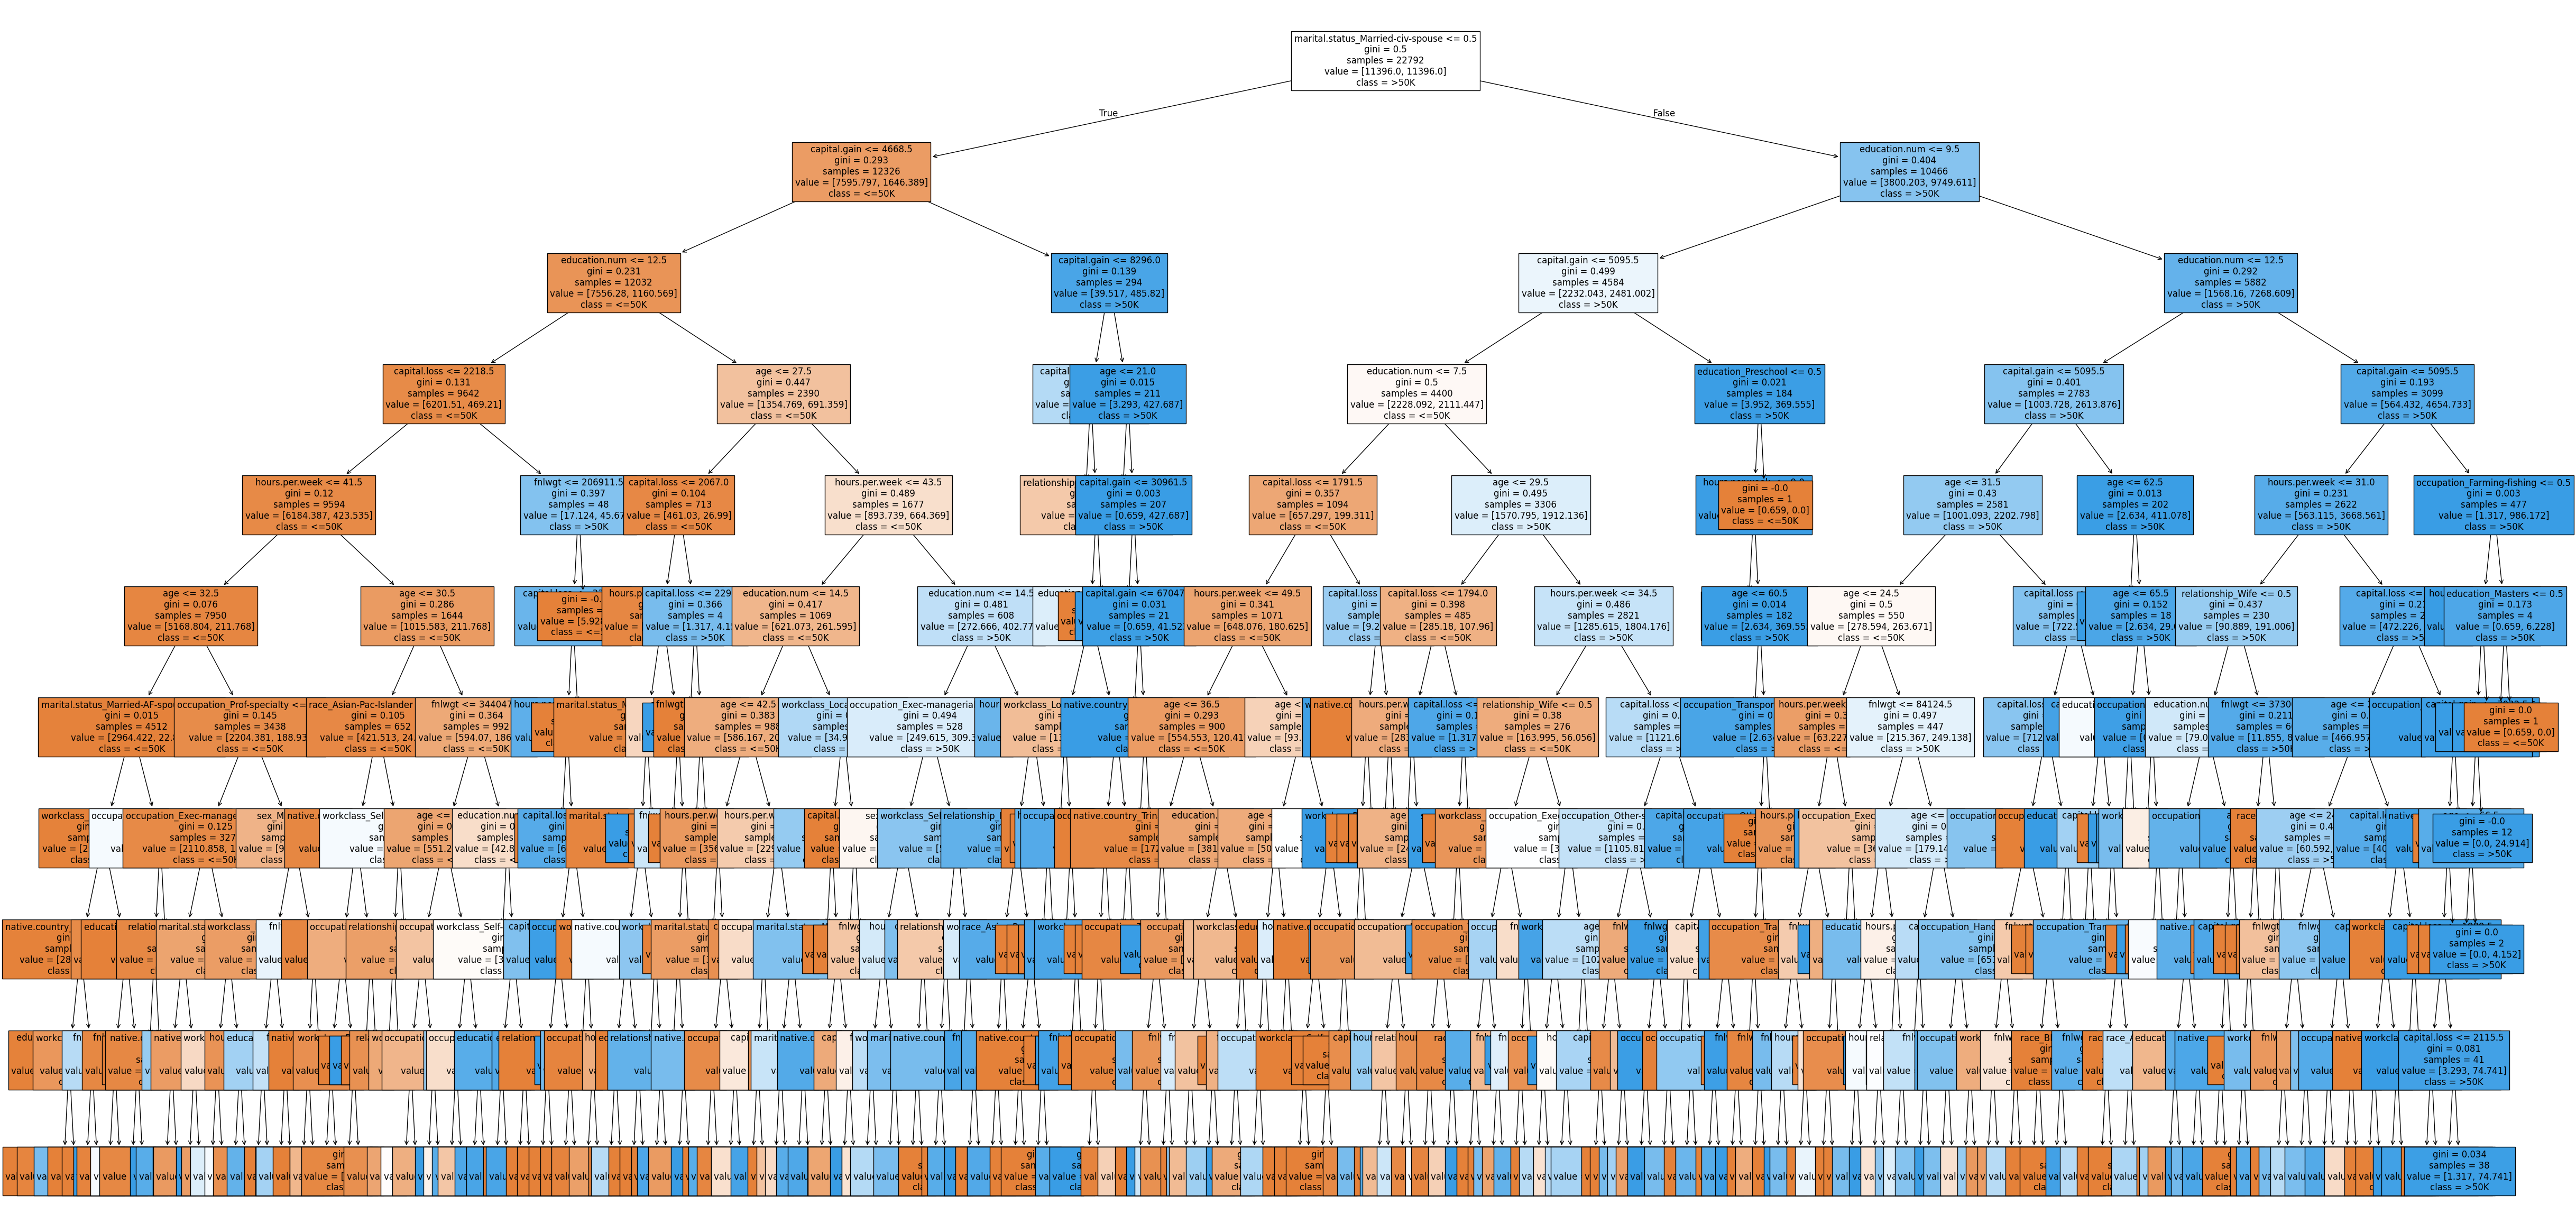

In [ ]:
# Definir features (X) e alvo (y)
X = encoded_df.drop(columns=["income"])
y = encoded_df["income"]

# Dividir os dados em treino e teste, garantindo balanceamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Criar e treinar a árvore de decisão
clf = DecisionTreeClassifier(max_depth=10, class_weight="balanced", random_state=42)

clf.fit(X_train, y_train)

# Fazer previsões
y_pred = clf.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia da Árvore de Decisão: {accuracy:.2f}")

# Visualizar a árvore de decisão
plt.figure(figsize=(60,30))
plot_tree(clf, feature_names=X.columns, class_names=["<=50K", ">50K"], filled=True, fontsize=12)
plt.show()


O modelo de árvore de decisão utiliza diversas variáveis (X) para prever a renda de um indivíduo, incluindo age, occupation, education, sex, entre outras, enquanto a variável-alvo (y) contém apenas a informação binária income, onde 0 representa <=50K e 1 representa >50K.

Para garantir um conjunto de dados balanceado, ele é dividido em 70% para treino e 30% para teste, preservando a proporção entre 0s e 1s através do parâmetro stratify=y, e mantendo a reprodutibilidade com random_state=42.

O modelo então cria uma árvore de decisão com profundidade máxima de 10 (max_depth=10), permitindo mais divisões nos dados, e aplica class_weight="balanced" para corrigir o desbalanceamento, evitando que a classe income = 1 seja subrepresentada.

Após o treinamento (fit()), o algoritmo aprende regras de decisão para separar income = 0 de income = 1, utilizando essas regras para prever a classificação binária dos exemplos de teste. As previsões (y_pred) são comparadas com os valores reais (y_test) e a acurácia do modelo é calculada, sendo 80% neste caso, indicando que o modelo acertou 80% das previsões.

Finalmente, uma representação gráfica da árvore é gerada, mostrando critérios de decisão como "education > 12?" ou "capital.gain > 5000?", onde cada nó da árvore divide os dados até alcançar a classificação binária final de income = 0 ou income = 1.

### Random Forest

Também farei um Random Forest para fazer a classificação binária a fins de comparação com a Decision Tree.

Este método combina múltiplas árvores de decisão, o que reduz o risco de overfitting e melhora as previsões, especialmente em conjuntos de dados grandes e complexos.

In [ ]:
# Initialize the Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight="balanced")

# Train the model
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_clf.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Acurácia do Random Forest: {accuracy_rf:.2f}")


Acurácia do Random Forest: 0.79


Este código implementa um modelo de Random Forest para classificação binária (income = 0 ou income = 1), utilizando um conjunto de árvores de decisão para melhorar a precisão e reduzir overfitting, combinando previsões de múltiplas árvores para obter um resultado mais estável e confiável.

Ele define 100 árvores (n_estimators=100) para garantir robustez, limita a profundidade máxima das árvores em 10 níveis (max_depth=10) para evitar overfitting e aplica class_weight="balanced" para tratar o desbalanceamento entre as classes. Além disso, fixa random_state=42 para garantir que os resultados sejam reprodutíveis.

Durante o treinamento (X_train, y_train), cada árvore aprende padrões com base em subconjuntos aleatórios dos dados, aumentando a generalização do modelo. Após o treino, o modelo utiliza as regras aprendidas para prever income = 0 ou income = 1 em novos exemplos de teste (X_test).

As previsões (y_pred_rf) são comparadas com os valores reais (y_test) para calcular a taxa de acerto do modelo, exibindo sua acurácia e mostrando quantos exemplos foram classificados corretamente. Esse processo garante que o Random Forest reduza overfitting, aprimore precisão ao combinar várias decisões em uma única previsão final e determine a importância dos atributos, permitindo identificar quais variáveis influenciam mais a previsão de renda.

### Comparando os dois métodos

In [ ]:
# Predictions
y_pred_dt = clf.predict(X_test)  # Decision Tree Predictions
y_pred_rf = rf_clf.predict(X_test)  # Random Forest Predictions

# Metrics Function
def evaluate_model(model_name, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"🔹 {model_name}:")
    print(f"   Accuracy: {accuracy:.2f}")
    print(f"   Precision: {precision:.2f}")
    print(f"   Recall: {recall:.2f}")
    print(f"   F1-score: {f1:.2f}\n")

# Evaluate both models
evaluate_model("Decision Tree", y_test, y_pred_dt)
evaluate_model("Random Forest", y_test, y_pred_rf)


🔹 Decision Tree:
   Accuracy: 0.80
   Precision: 0.55
   Recall: 0.85
   F1-score: 0.67

🔹 Random Forest:
   Accuracy: 0.79
   Precision: 0.54
   Recall: 0.88
   F1-score: 0.67



Comparando os modelos Árvore de Decisão e Random Forest, temos que a Árvore de Decisão apresentou 80% de acurácia, ligeiramente superior ao 79% do Random Forest, indicando que ambos classificam corretamente a maioria dos casos.

No entanto, a precisão foi moderada em ambos os modelos (0.55 para Árvore de Decisão e 0.54 para Random Forest), sugerindo que ainda há falsos positivos.

O recall foi maior no Random Forest (0.88) do que na Árvore de Decisão (0.85), o que significa que o Random Forest identifica melhor os casos >50K, minimizando falsos negativos.

O F1-score foi igual para ambos (0.67), equilibrando precisão e recall, mas evidenciando necessidade de ajustes para melhorar a precisão.

Dessa forma, se o objetivo for maximizar recall, evitando que casos >50K sejam perdidos, o Random Forest é a melhor escolha. No entanto, se o objetivo é um modelo mais simples e rápido, a Árvore de Decisão já oferece um desempenho sólido.

#### Matriz de Confusão

A matriz de confusão serve para avaliar a performance dos modelos Árvore de Decisão e Random Forest, identificando acertos e erros (Verdadeiros Positivos, Verdadeiros Negativos, Falsos Positivos e Falsos Negativos) nas previsões de renda (<=50K ou >50K).

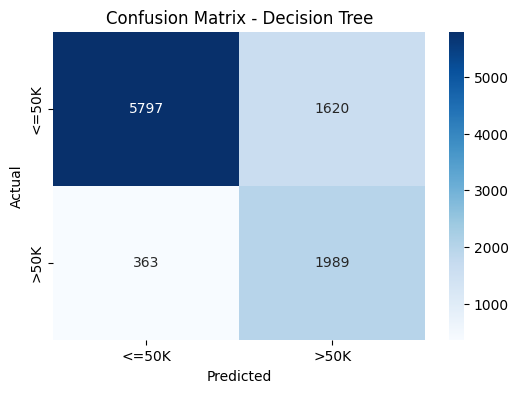

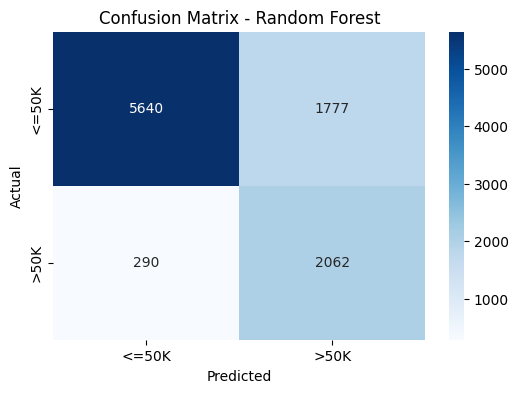

In [ ]:
# Function for plotting confusion matrix
def plot_confusion_matrix(model_name, y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["<=50K", ">50K"], yticklabels=["<=50K", ">50K"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Plot matrices for both models
plot_confusion_matrix("Decision Tree", y_test, y_pred_dt)
plot_confusion_matrix("Random Forest", y_test, y_pred_rf)



A Árvore de Decisão apresentou 5478 acertos para <=50K e 2071 para >50K, mas teve 1939 falsos positivos (casos <=50K classificados erroneamente como >50K) e 281 falsos negativos.

Já o Random Forest acertou 5640 casos <=50K e 2062 >50K, apresentando menos falsos positivos (1777), mas um número ligeiramente maior de falsos negativos (290).

Comparando os dois modelos, o Random Forest mostrou melhor desempenho ao evitar falsos positivos, sendo mais preciso na classificação de <=50K, enquanto a Árvore de Decisão teve um recall um pouco melhor, identificando mais casos reais de >50K.

Assim, se a prioridade for reduzir falsos positivos, o Random Forest é a melhor opção, mas se o foco for maximizar a captura de >50K, a Árvore de Decisão pode ser mais adequada.

#### Gráfico de importância de atributos

Para visualizar e compreender quais características do conjunto de dados têm maior impacto na previsão ou decisão do modelo, ou seja, identificar quais atributos são mais influentes e interpretar os resultados de forma mais informada, faremos também um Gráfico de Importância de Atributos.

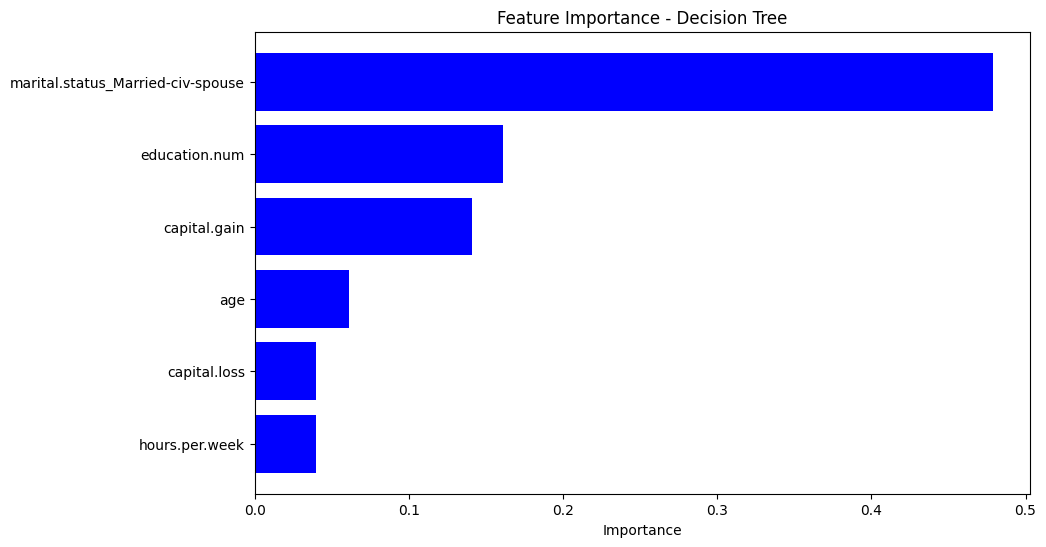

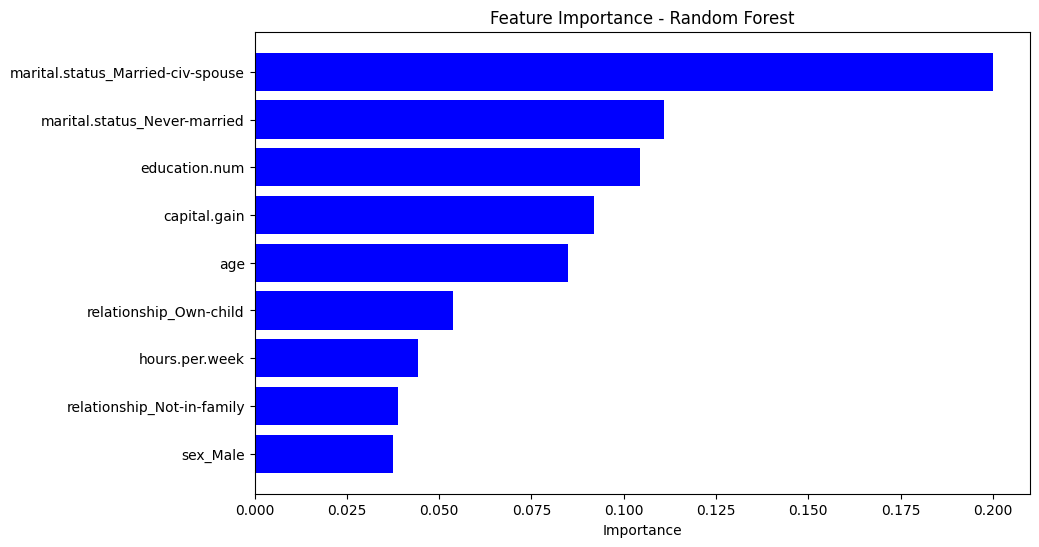

In [ ]:
# Feature importance plot (only values > 0)
def plot_feature_importance(model, model_name):
    importances = model.feature_importances_
    sorted_idx = importances.argsort()[::-1]  # Sort importance

    # Filter features with importance greater than 0.025
    valid_indices = sorted_idx[importances[sorted_idx] > 0.025]

    plt.figure(figsize=(10,6))
    plt.barh(X.columns[valid_indices], importances[valid_indices], color="blue")
    plt.xlabel("Importance")
    plt.title(f"Feature Importance - {model_name}")
    plt.gca().invert_yaxis()
    plt.show()

# Plot for both models
plot_feature_importance(clf, "Decision Tree")
plot_feature_importance(rf_clf, "Random Forest")


Para ambos os modelos, árvore de decisão e Random Forest, o atributo marital.status_Married-civ-spouse é o mais influente na previsão da renda, sugerindo que ser casado com cônjuge civil é um indicador chave.

O education.num e capital.gain também são importantes, indicando o papel significativo da educação e de ganhos financeiros adicionais na previsão de renda.

Enquanto a árvore de decisão considera menos atributos, o Random Forest incorpora um maior número de características, como marital.status_Never-married, age, relationship_Own-child, hours.per.week, entre outros, tornando-o mais abrangente na análise.